# Import data, merge to master dataset

In [215]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import pickle


In [2]:
resale_1990_1999 = pd.read_csv('Data/resale-flat-prices-based-on-approval-date-1990-1999.csv')
resale_2000_2012 = pd.read_csv('Data/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
resale_2012_2014 = pd.read_csv('Data/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')
resale_2015_2016 = pd.read_csv('Data/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
resale_2017 = pd.read_csv('Data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [88]:
resale_2000_2012.merge(resale_2012_2014, on=['block', 'street_name', 'floor_area_sqm', 'flat_type', 'resale_price', 'storey_range', 'month'])
# Data shifted from using approval date to registration date, however, no overlap was found. Suspect that dataset has already been cleaned to be date consistent. No further handling of dates required.

,month,town_x,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model_x,lease_commence_date_x,resale_price,town_y,flat_model_y,lease_commence_date_y


In [89]:
all_resale = result = pd.concat([resale_1990_1999, resale_2000_2012, resale_2012_2014, resale_2015_2016, resale_2017], axis=0, ignore_index=True)

# EDA

In [106]:
print(all_resale.shape)
print(all_resale.drop_duplicates().shape)
all_resale[all_resale.duplicated(keep=False)].sort_values(by=['street_name'])

(826581, 15)
(824760, 15)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year,storey_midpoint,lease_diff_years,remaining_lease_calc
749745,2017-03-01,SEMBAWANG,EXECUTIVE,360C,ADMIRALTY DR,07 TO 09,131.0,PREMIUM APARTMENT,2001-01-01,468000.0,83 years 06 months,2017,8.0,16,83
749749,2017-03-01,SEMBAWANG,EXECUTIVE,360C,ADMIRALTY DR,07 TO 09,131.0,PREMIUM APARTMENT,2001-01-01,468000.0,83 years 06 months,2017,8.0,16,83
728875,2016-02-01,SEMBAWANG,4 ROOM,467,ADMIRALTY DR,07 TO 09,102.0,PREMIUM APARTMENT,2001-01-01,365000.0,84,2016,8.0,15,84
728874,2016-02-01,SEMBAWANG,4 ROOM,467,ADMIRALTY DR,07 TO 09,102.0,PREMIUM APARTMENT,2001-01-01,365000.0,84,2016,8.0,15,84
476316,2005-09-01,SEMBAWANG,4 ROOM,467B,ADMIRALTY DR,01 TO 03,102.0,PREMIUM APARTMENT,2001-01-01,228000.0,NaN,2005,2.0,4,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164344,1997-07-01,JURONG WEST,3 ROOM,5,YUNG PING RD,07 TO 09,64.0,IMPROVED,1973-01-01,139000.0,NaN,1997,8.0,24,75
3053,1990-03-01,JURONG WEST,3 ROOM,6,YUNG PING RD,01 TO 03,64.0,IMPROVED,1973-01-01,23400.0,NaN,1990,2.0,17,82
3055,1990-03-01,JURONG WEST,3 ROOM,6,YUNG PING RD,01 TO 03,64.0,IMPROVED,1973-01-01,23400.0,NaN,1990,2.0,17,82
259595,1999-06-01,JURONG WEST,3 ROOM,6,YUNG PING RD,01 TO 03,64.0,IMPROVED,1973-01-01,83000.0,NaN,1999,2.0,26,73


In [91]:
all_resale['town'].value_counts().sort_index()

town
ANG MO KIO         48237
BEDOK              61400
BISHAN             19522
BUKIT BATOK        40444
BUKIT MERAH        30518
BUKIT PANJANG      24241
BUKIT TIMAH         2283
CENTRAL AREA        6345
CHOA CHU KANG      33388
CLEMENTI           25755
GEYLANG            25679
HOUGANG            45476
JURONG EAST        22864
JURONG WEST        60708
KALLANG/WHAMPOA    24030
LIM CHU KANG          64
MARINE PARADE       7388
PASIR RIS          30267
PUNGGOL            12336
QUEENSTOWN         25922
SEMBAWANG          11016
SENGKANG           23903
SERANGOON          21125
TAMPINES           73101
TOA PAYOH          28525
WOODLANDS          58735
YISHUN             63309
Name: count, dtype: int64

In [92]:
all_resale['flat_type'].value_counts().sort_index()

flat_type
1 ROOM                1273
2 ROOM                9863
3 ROOM              272580
4 ROOM              309314
5 ROOM              170408
EXECUTIVE            62641
MULTI GENERATION       279
MULTI-GENERATION       223
Name: count, dtype: int64

In [93]:
all_resale['storey_range'].value_counts().sort_index()

storey_range
01 TO 03    168985
01 TO 05      2700
04 TO 06    209705
06 TO 10      2474
07 TO 09    189109
10 TO 12    160250
11 TO 15      1259
13 TO 15     52212
16 TO 18     19449
16 TO 20       265
19 TO 21      9422
21 TO 25        92
22 TO 24      6053
25 TO 27      2544
26 TO 30        39
28 TO 30      1049
31 TO 33       265
31 TO 35         2
34 TO 36       267
36 TO 40         7
37 TO 39       255
40 TO 42       132
43 TO 45        16
46 TO 48        21
49 TO 51         9
Name: count, dtype: int64

In [94]:
all_resale[['flat_type','flat_model']].value_counts().sort_index()

flat_type         flat_model        
1 ROOM            IMPROVED               827
                  Improved               446
2 ROOM            2-ROOM                  21
                  2-room                  19
                  DBSS                     1
                                        ... 
EXECUTIVE         PREMIUM APARTMENT        5
                  Premium Apartment     3324
                  Premium Maisonette      82
MULTI GENERATION  MULTI GENERATION       279
MULTI-GENERATION  Multi Generation       223
Name: count, Length: 70, dtype: int64

<Axes: title={'center': 'Resale Counts by Year'}, xlabel='year'>

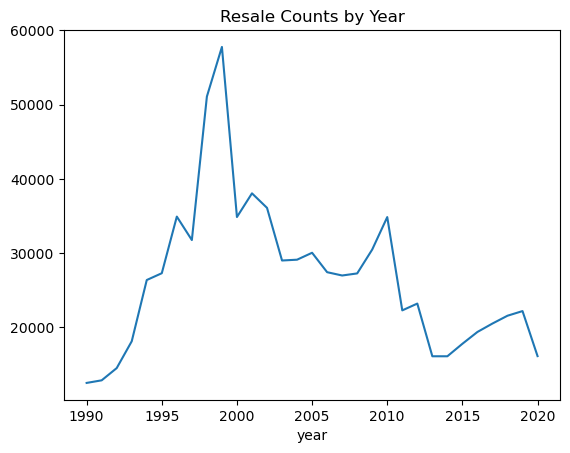

In [95]:
# month and year
all_resale['month'] = pd.to_datetime(all_resale['month'])
all_resale['year'] = all_resale['month'].dt.year
all_resale['year'].value_counts().sort_index().plot(kind='line', title='Resale Counts by Year')

In [96]:
print(all_resale['month'].min())
print(all_resale['month'].max())

1990-01-01 00:00:00
2020-09-01 00:00:00


<Axes: title={'center': 'Average Resale Price by Year'}, xlabel='year'>

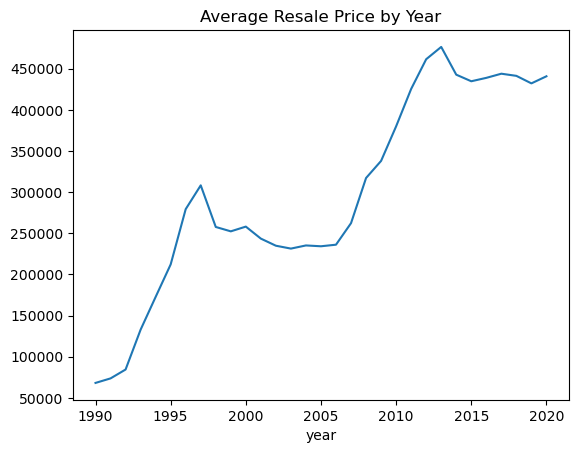

In [97]:
all_resale.groupby('year')['resale_price'].mean().plot(kind='line', marker='', title='Average Resale Price by Year')

# Data Cleanup

In [98]:
# clean multi generation string
all_resale['flat_type'] = all_resale['flat_type'].str.replace('-', ' ', regex=False)
print(all_resale['flat_type'].value_counts().sort_index())
# clean flat model case
all_resale['flat_model'] = all_resale['flat_model'].str.upper()
print(all_resale['flat_model'].value_counts().sort_index())


flat_type
1 ROOM                1273
2 ROOM                9863
3 ROOM              272580
4 ROOM              309314
5 ROOM              170408
EXECUTIVE            62641
MULTI GENERATION       502
Name: count, dtype: int64
flat_model
2-ROOM                        40
ADJOINED FLAT               1085
APARTMENT                  32004
DBSS                        1609
IMPROVED                  217356
IMPROVED-MAISONETTE          114
MAISONETTE                 26909
MODEL A                   228389
MODEL A-MAISONETTE          1889
MODEL A2                    9109
MULTI GENERATION             502
NEW GENERATION            177570
PREMIUM APARTMENT          35035
PREMIUM APARTMENT LOFT        31
PREMIUM MAISONETTE            82
SIMPLIFIED                 53960
STANDARD                   39854
TERRACE                      642
TYPE S1                      272
TYPE S2                      129
Name: count, dtype: int64


In [99]:
# storey estimate
# Function to get the midpoint of a storey range
def get_midpoint(storey_range):
    # Split the string by ' TO '
    start, end = storey_range.split(' TO ')
    # Calculate the midpoint
    return (int(start) + int(end)) / 2

# Apply the function to the 'storey_range' column and create a new 'storey_midpoint' column
all_resale['storey_midpoint'] = all_resale['storey_range'].apply(get_midpoint)
all_resale['storey_midpoint'].value_counts().sort_index()


storey_midpoint
2.0     168985
3.0       2700
5.0     209705
8.0     191583
11.0    160250
13.0      1259
14.0     52212
17.0     19449
18.0       265
20.0      9422
23.0      6145
26.0      2544
28.0        39
29.0      1049
32.0       265
33.0         2
35.0       267
38.0       262
41.0       132
44.0        16
47.0        21
50.0         9
Name: count, dtype: int64

In [104]:
# remaining_lease_calculation
# Calculate the difference between lease commence date and month
all_resale['lease_commence_date'] = pd.to_datetime(all_resale['lease_commence_date'], format='%Y')
all_resale['month'] = pd.to_datetime(all_resale['month'], format='%Y-%m')
# Calculate the difference in years
all_resale['lease_diff_years'] = all_resale['month'].dt.year - all_resale['lease_commence_date'].dt.year
all_resale['remaining_lease_calc'] = 99 - all_resale['lease_diff_years']

# Display the result
all_resale[['lease_commence_date', 'month', 'lease_diff_years', 'remaining_lease', 'remaining_lease_calc']]


,lease_commence_date,month,lease_diff_years,remaining_lease,remaining_lease_calc
0,1977-01-01,1990-01-01,13,NaN,86
1,1977-01-01,1990-01-01,13,NaN,86
2,1977-01-01,1990-01-01,13,NaN,86
3,1977-01-01,1990-01-01,13,NaN,86
4,1976-01-01,1990-01-01,14,NaN,85
...,...,...,...,...,...
826576,1987-01-01,2020-09-01,33,66 years 03 months,66
826577,1987-01-01,2020-09-01,33,65 years 06 months,66
826578,1987-01-01,2020-09-01,33,66 years 04 months,66
826579,1987-01-01,2020-09-01,33,66 years 03 months,66


# Feature Engineering

In [124]:
# rpi adjusted price
# Get hdb resale price index from singstats
# API endpoint
url = "https://tablebuilder.singstat.gov.sg/api/table/tabledata/M212161"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

# Fetch data
response = requests.get(url, headers=headers)
rpi_data = response.json()

# Extract quarterly data
rpi_quarters = rpi_data['Data']['row'][0]['columns']
rpi_df = pd.DataFrame(rpi_quarters)

quarter_month_map = {
    '1Q': ['01', '02', '03'],
    '2Q': ['04', '05', '06'],
    '3Q': ['07', '08', '09'],
    '4Q': ['10', '11', '12']
}

# Split the 'key' column into 'year' and 'quarter'
rpi_df[['year', 'quarter']] = rpi_df['key'].str.split(' ', expand=True)

# For each quarter, map it to its respective months
expanded_rpi = []

for _, row in rpi_df.iterrows():
    year = row['year']
    quarter = row['quarter']
    months = quarter_month_map[quarter]
    for month in months:
        expanded_rpi.append({
            'month': f'{year}-{month}-01',  # Assign each RPI to the 1st of the month
            'rpi': float(row['value'])
        })

# Create the final expanded RPI DataFrame
rpi_monthly_df = pd.DataFrame(expanded_rpi)

# Ensure the 'month' column is in datetime format for easy merging
rpi_monthly_df['month'] = pd.to_datetime(rpi_monthly_df['month'])

# Check the result
rpi_monthly_df

,month,rpi
0,1990-01-01,24.3
1,1990-02-01,24.3
2,1990-03-01,24.3
3,1990-04-01,24.4
4,1990-05-01,24.4
...,...,...
418,2024-11-01,197.9
419,2024-12-01,197.9
420,2025-01-01,201.0
421,2025-02-01,201.0


In [130]:
all_resale_rpi = all_resale.merge(rpi_monthly_df, on='month', how='left')
all_resale_rpi['rpi_adj_resale_price'] = all_resale_rpi['resale_price']/all_resale_rpi['rpi']
all_resale_rpi['rpi_adj_resale_ppsm'] = all_resale_rpi['rpi_adj_resale_price']/all_resale_rpi['floor_area_sqm']

<Axes: title={'center': 'Average RPI adjusted Resale PPSM by Year'}, xlabel='year'>

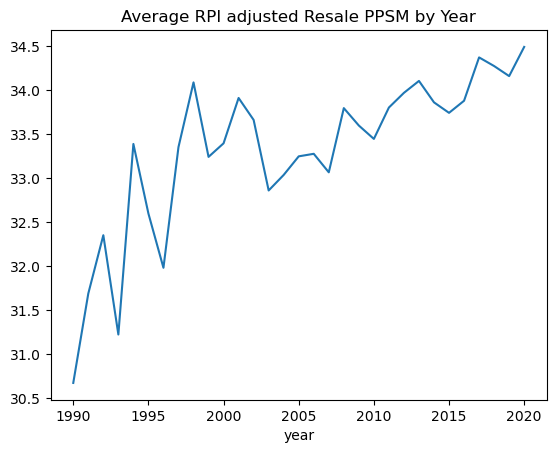

In [138]:
all_resale_rpi.groupby('year')['rpi_adj_resale_ppsm'].mean().plot(kind='line', marker='', title='Average RPI adjusted Resale PPSM by Year')

In [142]:
all_resale_rpi.groupby('town')['rpi_adj_resale_ppsm'].mean().sort_values(ascending=False)

town
MARINE PARADE      43.335568
BUKIT TIMAH        42.887826
CENTRAL AREA       42.714805
BISHAN             42.209684
BUKIT MERAH        39.678258
KALLANG/WHAMPOA    36.986031
QUEENSTOWN         36.928291
TOA PAYOH          36.255310
SERANGOON          35.489705
CLEMENTI           35.362660
PUNGGOL            35.193119
TAMPINES           34.928696
PASIR RIS          34.915728
GEYLANG            34.090654
SENGKANG           33.576531
BEDOK              33.275450
ANG MO KIO         33.175750
HOUGANG            32.804034
JURONG EAST        31.323064
BUKIT BATOK        31.227232
CHOA CHU KANG      30.849512
SEMBAWANG          30.618701
YISHUN             30.322410
BUKIT PANJANG      30.196741
JURONG WEST        29.211958
WOODLANDS          28.740683
LIM CHU KANG       16.250535
Name: rpi_adj_resale_ppsm, dtype: float64

In [143]:
all_resale_rpi.groupby('flat_type')['rpi_adj_resale_ppsm'].mean().sort_values(ascending=False)

flat_type
MULTI GENERATION    39.582953
EXECUTIVE           37.378618
5 ROOM              35.959872
4 ROOM              33.453508
3 ROOM              30.909509
2 ROOM              29.463833
1 ROOM              23.643140
Name: rpi_adj_resale_ppsm, dtype: float64

In [135]:
all_resale_rpi['rpi_adj_resale_ppsm'].describe()

count    826581.000000
mean         33.369756
std           7.249987
min           5.266623
25%          28.719877
50%          32.359530
75%          36.782135
max          96.756911
Name: rpi_adj_resale_ppsm, dtype: float64

In [137]:
all_resale_rpi.sort_values(by=['rpi_adj_resale_ppsm'], ascending=False)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year,storey_midpoint,lease_diff_years,remaining_lease_calc,rpi,rpi_adj_resale_price,rpi_adj_resale_ppsm
817349,2020-06-01,CENTRAL AREA,4 ROOM,1B,CANTONMENT RD,40 TO 42,93.0,TYPE S1,2011-01-01,1186888.0,89 years 09 months,2020,41.0,9,90,131.9,8998.392722,96.756911
37663,1992-11-01,CENTRAL AREA,4 ROOM,233,BAIN ST,22 TO 24,82.0,IMPROVED,1980-01-01,214000.0,NaN,1992,23.0,12,87,28.6,7482.517483,91.250213
799152,2019-07-01,CENTRAL AREA,4 ROOM,1F,CANTONMENT RD,49 TO 51,94.0,TYPE S1,2011-01-01,1110000.0,90 years 06 months,2019,50.0,8,91,130.9,8479.755539,90.210165
11907,1990-12-01,CENTRAL AREA,4 ROOM,334,KRETA AYER RD,16 TO 18,83.0,IMPROVED,1981-01-01,183000.0,NaN,1990,17.0,9,90,24.7,7408.906883,89.263938
22669,1991-10-01,SERANGOON,5 ROOM,208,SERANGOON CTRL,01 TO 03,122.0,IMPROVED,1985-01-01,270000.0,NaN,1991,2.0,6,93,25.1,10756.972112,88.171903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47574,1993-07-01,QUEENSTOWN,2 ROOM,55,C'WEALTH DR,01 TO 03,46.0,STANDARD,1970-01-01,14500.0,NaN,1993,2.0,23,76,47.7,303.983229,6.608331
53166,1993-11-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977-01-01,10000.0,NaN,1993,11.0,16,83,49.0,204.081633,6.583278
6644,1990-07-01,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,01 TO 03,31.0,IMPROVED,1975-01-01,5000.0,NaN,1990,2.0,15,84,25.0,200.000000,6.451613
50071,1993-09-01,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,07 TO 09,31.0,IMPROVED,1975-01-01,9000.0,NaN,1993,8.0,18,81,47.7,188.679245,6.086427


In [160]:
# bala decay adjustment
all_resale_rpi['rpi_bala_adj_ppsm'] = all_resale_rpi['rpi_adj_resale_ppsm']*100/(26.365 * np.log(all_resale_rpi['remaining_lease_calc']) - 27.997)
all_resale_rpi

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year,storey_midpoint,lease_diff_years,remaining_lease_calc,rpi,rpi_adj_resale_price,rpi_adj_resale_ppsm,rpi_bala_adj_ppsm
817349,2020-06-01,CENTRAL AREA,4 ROOM,1B,CANTONMENT RD,40 TO 42,93.0,TYPE S1,2011-01-01,1186888.0,89 years 09 months,2020,41.0,9,90,131.9,8998.392722,96.756911,106.748010
37663,1992-11-01,CENTRAL AREA,4 ROOM,233,BAIN ST,22 TO 24,82.0,IMPROVED,1980-01-01,214000.0,NaN,1992,23.0,12,87,28.6,7482.517483,91.250213,101.675322
799152,2019-07-01,CENTRAL AREA,4 ROOM,1F,CANTONMENT RD,49 TO 51,94.0,TYPE S1,2011-01-01,1110000.0,90 years 06 months,2019,50.0,8,91,130.9,8479.755539,90.210165,99.206388
11907,1990-12-01,CENTRAL AREA,4 ROOM,334,KRETA AYER RD,16 TO 18,83.0,IMPROVED,1981-01-01,183000.0,NaN,1990,17.0,9,90,24.7,7408.906883,89.263938,98.481315
22669,1991-10-01,SERANGOON,5 ROOM,208,SERANGOON CTRL,01 TO 03,122.0,IMPROVED,1985-01-01,270000.0,NaN,1991,2.0,6,93,25.1,10756.972112,88.171903,96.357485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47574,1993-07-01,QUEENSTOWN,2 ROOM,55,C'WEALTH DR,01 TO 03,46.0,STANDARD,1970-01-01,14500.0,NaN,1993,2.0,23,76,47.7,303.983229,6.608331,7.667809
53166,1993-11-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977-01-01,10000.0,NaN,1993,11.0,16,83,49.0,204.081633,6.583278,7.438251
6644,1990-07-01,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,01 TO 03,31.0,IMPROVED,1975-01-01,5000.0,NaN,1990,2.0,15,84,25.0,200.000000,6.451613,7.263572
50071,1993-09-01,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,07 TO 09,31.0,IMPROVED,1975-01-01,9000.0,NaN,1993,8.0,18,81,47.7,188.679245,6.086427,6.927206


In [180]:
#Get list of unique addresses
unique_addr = all_resale_rpi[['block','street_name']].drop_duplicates()
unique_addr.reset_index(drop=True, inplace=True)
unique_addr

,block,street_name
0,1B,CANTONMENT RD
1,233,BAIN ST
2,1F,CANTONMENT RD
3,334,KRETA AYER RD
4,208,SERANGOON CTRL
...,...,...
9274,5,SEMBAWANG RD
9275,1,SELETAR WEST FARMWAY 6
9276,4,LIM CHU KANG RD
9277,3,LIM CHU KANG RD


In [182]:
#map x,y coordinates to addresses using onemap API
def get_onemap_result(search_val):
    url_search = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={search_val}&returnGeom=Y&getAddrDetails=N"
    try:
        one_map_response = requests.get(url_search)
        data = one_map_response.json()
        if data['found'] > 0:
            # Extract lat/lon of first result
            result_0 = data['results'][0]
            return result_0['X'], result_0['Y']
        else:
            return None, None
    except Exception as e:
        print(f"Error for {search_val}: {e}")
        return None, None

# Create new columns for lat/lon
X_list = []
Y_list = []

for i, row in unique_addr.iterrows():
    # print(f"{i}: {search_val} -> ({x}, {y})")
    search_val = f"{row['block']} {row['street_name']}"
    x, y = get_onemap_result(search_val)
    X_list.append(x)
    Y_list.append(y)
    # time.sleep(0.2)  # to avoid API throttling

unique_addr['x'] = X_list
unique_addr['y'] = Y_list

In [184]:
print(all_resale_rpi.shape)
df_master = all_resale_rpi.merge(unique_addr, on=['block', 'street_name'], how='left')
print(df_master.shape)

(826581, 19)
(826581, 21)


In [217]:
df_master['x'] = pd.to_numeric(df_master['x'])
df_master['y'] = pd.to_numeric(df_master['y'])
df_master.to_csv('Data/df_master.zip', compression='zip')

In [194]:
df_master

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,year,storey_midpoint,lease_diff_years,remaining_lease_calc,rpi,rpi_adj_resale_price,rpi_adj_resale_ppsm,rpi_bala_adj_ppsm,x,y
0,2020-06-01,CENTRAL AREA,4 ROOM,1B,CANTONMENT RD,40 TO 42,93.0,TYPE S1,2011-01-01,1186888.0,...,2020,41.0,9,90,131.9,8998.392722,96.756911,106.748010,28899.779202,28918.087942
1,1992-11-01,CENTRAL AREA,4 ROOM,233,BAIN ST,22 TO 24,82.0,IMPROVED,1980-01-01,214000.0,...,1992,23.0,12,87,28.6,7482.517483,91.250213,101.675322,30291.330140,31018.515361
2,2019-07-01,CENTRAL AREA,4 ROOM,1F,CANTONMENT RD,49 TO 51,94.0,TYPE S1,2011-01-01,1110000.0,...,2019,50.0,8,91,130.9,8479.755539,90.210165,99.206388,28876.222811,28717.680716
3,1990-12-01,CENTRAL AREA,4 ROOM,334,KRETA AYER RD,16 TO 18,83.0,IMPROVED,1981-01-01,183000.0,...,1990,17.0,9,90,24.7,7408.906883,89.263938,98.481315,29003.557010,29339.047281
4,1991-10-01,SERANGOON,5 ROOM,208,SERANGOON CTRL,01 TO 03,122.0,IMPROVED,1985-01-01,270000.0,...,1991,2.0,6,93,25.1,10756.972112,88.171903,96.357485,32495.954790,37356.269025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826576,1993-07-01,QUEENSTOWN,2 ROOM,55,C'WEALTH DR,01 TO 03,46.0,STANDARD,1970-01-01,14500.0,...,1993,2.0,23,76,47.7,303.983229,6.608331,7.667809,23966.756729,31047.039758
826577,1993-11-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977-01-01,10000.0,...,1993,11.0,16,83,49.0,204.081633,6.583278,7.438251,29045.715075,38609.483079
826578,1990-07-01,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,01 TO 03,31.0,IMPROVED,1975-01-01,5000.0,...,1990,2.0,15,84,25.0,200.000000,6.451613,7.263572,26449.194373,28980.230080
826579,1993-09-01,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,07 TO 09,31.0,IMPROVED,1975-01-01,9000.0,...,1993,8.0,18,81,47.7,188.679245,6.086427,6.927206,26449.194373,28980.230080


# Model development

In [216]:
# Features and target
X = df_master[['x', 'y', 'storey_midpoint']]
y = df_master['rpi_adj_resale_ppsm']

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# 1. Linear Regression
lr = LinearRegression()
lr_scores = cross_val_score(lr, X, y, scoring=scorer, cv=kf)
print(f'Linear Regression RMSE: {np.sqrt(-np.mean(lr_scores)):.2f}')
with open('Models/linear_regression_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

# 2. Linear Regression with L1 (Lasso)
model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=1.0))
])
lasso_scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
print(f'Lasso Regression RMSE: {np.sqrt(-np.mean(lasso_scores)):.2f}')
with open('Models/lasso_regression_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 3. K-Nearest Neighbors
# Define the parameter grid: number of neighbors to try
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])
param_grid = {
    'knn__n_neighbors': [3, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500],
    'knn__weights': ['uniform', 'distance']  # Optional: test different weighting strategies
}
# Set up GridSearchCV
grid_search = GridSearchCV(knn_pipeline, param_grid, scoring=scorer, cv=kf, n_jobs=-1)
# Fit on your data
grid_search.fit(X, y)
best_knn = grid_search.best_estimator_
# Best parameters and RMSE score
print("Best parameters:", grid_search.best_params_)
print(f'Best KNN RMSE: {np.sqrt(-grid_search.best_score_):.2f}')
with open('Models/best_knn_model.pkl', 'wb') as f:
    pickle.dump(best_knn, f)


# 4. XGBoost Regressor with GridSearchCV
xgb = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
grid = GridSearchCV(xgb, param_grid, cv=kf, scoring=scorer)
grid.fit(X, y)
best_xgb = grid.best_estimator_
xgb_scores = cross_val_score(best_xgb, X, y, scoring=scorer, cv=kf)
print(f'XGBoost RMSE: {np.sqrt(-np.mean(xgb_scores)):.2f}')
print(f'Best XGBoost Params: {grid.best_params_}')
with open('Models/best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

Linear Regression RMSE: 6.46
Lasso Regression RMSE: 6.67
Best parameters: {'knn__n_neighbors': 200, 'knn__weights': 'distance'}
Best KNN RMSE: 4.59
XGBoost RMSE: 5.47
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [211]:
# Save model